### Notebook to assess the number of fbw11/btrcp substrates identified in Tai Young Kim,1 et al. (doi:10.1128/MCB.00857-14) compared to our predictions. 
- Data extracted from Table S1 (Mass spectrometry data)
- BTRCP subtrates (all selected)
- fbw11 substrates - Those with a Log2(Median) > 0

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.externals import joblib
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import  precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interp

In [2]:
base="../" 
path_degrons = os.path.join(base,"data","predicte_degrons_properties.tsv.gz")
path_tp_btrcp = os.path.join(base,"internal","true_positives_btrcp.csv")
output_classifier_protein = os.path.join(base,"data","classifier_random.pickle")
path_output_plots = os.path.join(base,"plots","Figure1")

### Load data

In [3]:
df_data = pd.read_csv(path_degrons,sep="\t")
df_data=df_data[df_data["DEGRON"].str.contains("TRCP")]

### True positives of BTRCp

In [4]:
df_tp_btrcp = pd.read_csv(path_tp_btrcp,sep="\t")
tps_btrp=df_tp_btrcp["Hugo_Symbol"].values

In [5]:
cases_with_degron = list(df_data[df_data["Hugo_Symbol"].isin(tps_btrp)]["Hugo_Symbol"].unique())
cases_positives = df_data[(df_data["Prob_DEGRON"]>0.5)&(df_data["Hugo_Symbol"].isin(cases_with_degron))]["Hugo_Symbol"].unique()
cases_negatives = df_data[(df_data["Prob_DEGRON"]<0.5)&(df_data["Hugo_Symbol"].isin(cases_with_degron))&(~df_data["Hugo_Symbol"].isin(cases_positives))]["Hugo_Symbol"].unique()
print (f"{len(cases_positives)} True positives, {len(cases_negatives)}  False Negatives")
print (f"{len(cases_positives) / (len(cases_positives) + len(cases_negatives))} True positive rate")

7 True positives, 2  False Negatives
0.7777777777777778 True positive rate


### True positives of FBXW11
-- Select those cases with a Log2(Median) > 0

In [6]:
path_tp_fbw11 = os.path.join(base,"internal","true_positives_candidates_fbxw11.csv")
df_fbw11 = pd.read_csv(path_tp_fbw11,sep="\t")

In [7]:
tps_fbw11=df_fbw11[df_fbw11["Log2 (Median)"]>0]["Gene Name"].unique()

In [9]:
cases_with_degron = list(df_data[df_data["Hugo_Symbol"].isin(tps_fbw11)]["Hugo_Symbol"].unique())
cases_positives = df_data[(df_data["Prob_DEGRON"]>0.5)&(df_data["Hugo_Symbol"].isin(cases_with_degron))]["Hugo_Symbol"].unique()
cases_positives_annotated = df_data[(df_data["Annotated"]=="YES")&(df_data["Hugo_Symbol"].isin(cases_with_degron))]["Hugo_Symbol"].unique()
cases_negatives = df_data[(df_data["Prob_DEGRON"]<0.5)&(df_data["Hugo_Symbol"].isin(cases_with_degron))&(~df_data["Hugo_Symbol"].isin(cases_positives))]["Hugo_Symbol"].unique()
print (f"{len(cases_positives)} True positives, {len(cases_negatives)}  False Negatives")
print (f"{len(cases_positives) / (len(cases_positives) + len(cases_negatives))} True positive rate")
print (f"{len(cases_positives_annotated)}  Cases in training set")

23 True positives, 3  False Negatives
0.8846153846153846 True positive rate
8  Cases in training set


### Select positives for AUC

In [9]:
random_state=np.random.RandomState(seed=0)
covariates =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL","ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines","HELIX","STRAND","RIG_SCORE","Domain_pfam"]
covariates_names = {"Z_ASA":"S.A.","Z_FCONS":"FCONS","Z_SS_C":"COIL","Z_SS_H":"HELIX","Z_SS_E":"SHEET","Z_DSS":"DISORDER","Z_RIG":"RIGIDITY","Z_ANCHOR":"ANCHOR","Z_DOMAIN":"DOMAIN","Z_FLANKING_UB_LYSINE":"UB_SITES","Z_PTMS":"PHOSPHO_SITES"}
response_var = "IS_DEGRON"

In [10]:
selected_cases=df_data[df_data["Hugo_Symbol"].isin(tps_fbw11)].groupby(["Hugo_Symbol"],as_index=False).agg({"Prob_DEGRON":np.nanmax})
positives = selected_cases.merge(df_data)

### True negatives of FBXW11
-- GIven the 26 proteins select random motif of the protein and use them as TN set

In [11]:
simulated = os.path.join(base,"data","simulated_degrons.tsv.gz")
df_simulated = pd.read_csv(simulated,sep="\t",compression="gzip")
df_simulated = df_simulated[df_simulated["CONS_SCORE"]>0]
df_simulated=df_simulated.dropna(axis=0)
# Plot it
thresholds = np.linspace(0, 0.99, 20)
precision_degron = list(np.zeros(20))
precision_random = list(np.zeros(20))
recall_degron = list(np.zeros(20))
recall_random = list(np.zeros(20))
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
clf = joblib.load(output_classifier_protein) 

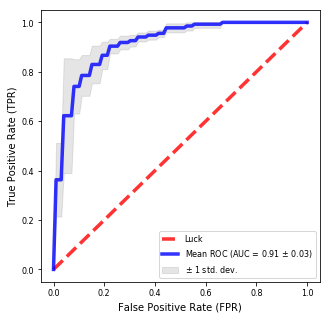

In [12]:
for N in range(0,5): # 5 iterations
    negatives = df_simulated.sample(n=len(positives))
    # Prepare the dataset 
    p_probs = clf.predict_proba(negatives[covariates])
    negatives["Prob_DEGRON"] = [l[1] for l in p_probs]
    negatives["Prob_RANDOM"] = [l[0] for l in p_probs]
    negatives["Predicted_Class"] = clf.predict(negatives[covariates])
    negatives["True_Class"] = 0.0
    positives["True_Class"] = 1.0
    df_dataset = pd.concat([positives,negatives],sort=True)
    true_labels = df_dataset["True_Class"].values
    predicted_probs= df_dataset["Prob_DEGRON"]
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(true_labels,predicted_probs)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
fig,ax = plt.subplots(figsize=(5,5))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
             label='Luck', alpha=.8)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=3.5, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate (FPR)',fontsize=10)
ax.set_ylabel('True Positive Rate (TPR)',fontsize=10)
#ax.set_title('Area Under the Curve',fontsize=14)
plt.legend(loc="lower right",fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(path_output_plots+'/FigureS1e_roc_fbw11_negatives_simulated.pdf', dpi=800,bbox_inches="tight")
plt.show()

### Load negatives from the manuscript 
-- Defined as those non significant with a Log2(Median) < 0

In [13]:
path_tn_fbw11 = os.path.join(base,"internal","true_negatives_candidates_fbxw11.csv")
df_fbw11_n = pd.read_csv(path_tn_fbw11,sep="\t")
genes_negatives=df_fbw11_n[df_fbw11_n["Log2 (Median)"]<0]["Gene Name"].unique()

### AUC

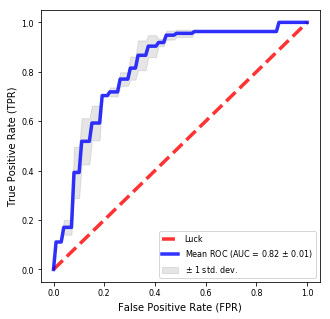

Precision degron : 0.854
Precision random : 0.719
Recall degron : 0.652
Recall random : 0.889


In [14]:
# Plot it
thresholds = np.linspace(0, 0.99, 20)
precision_degron = []
precision_random = []
recall_degron = []
recall_random = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
clf = joblib.load(output_classifier_protein) 
for N in range(0,5): # 5 iterations
    negatives = df_data[(df_data["Hugo_Symbol"].isin(genes_negatives))&(~df_data["Hugo_Symbol"].isin(tps_fbw11))].sample(n=len(positives))
    # Prepare the dataset 
    p_probs = clf.predict_proba(negatives[covariates])
    negatives["Prob_DEGRON"] = [l[1] for l in p_probs]
    negatives["Prob_RANDOM"] = [l[0] for l in p_probs]
    negatives["Predicted_Class"] = clf.predict(negatives[covariates])
    negatives["True_Class"] = 0.0
    positives["True_Class"] = 1.0
    df_dataset = pd.concat([positives,negatives],sort=True)
    true_labels = df_dataset["True_Class"].values
    predicted_probs= df_dataset["Prob_DEGRON"]
    # Compute stats
    precision,recall,_,_ = precision_recall_fscore_support(true_labels, df_dataset["Predicted_Class"].values)
    precision_degron.append(precision[0])
    precision_random.append(precision[1])
    recall_degron.append(recall[0])
    recall_random.append(recall[1])

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(true_labels,predicted_probs)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
fig,ax = plt.subplots(figsize=(5,5))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
             label='Luck', alpha=.8)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=3.5, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate (FPR)',fontsize=10)
ax.set_ylabel('True Positive Rate (TPR)',fontsize=10)
#ax.set_title('Area Under the Curve',fontsize=14)
plt.legend(loc="lower right",fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(path_output_plots+'/FigureS1e_roc_fbw11_negatives_observed.pdf', dpi=800,bbox_inches="tight")
plt.show()
print(f'Precision degron : {np.nanmean(precision_degron):.3}')
print(f'Precision random : {np.nanmean(precision_random):.3}')
print(f'Recall degron : {np.nanmean(recall_degron):.3}')
print(f'Recall random : {np.nanmean(recall_random):.3}')